In [1]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'/min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180801000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

data1H = Time_dict.set_index('datetime')

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
#大阳线
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

4.2205727100372314
Initialize dataview success.


In [2]:
Big_Up = dv1H.add_formula('Big_Up','If((close/open>1.02) && (high/low<(close/open+0.02)), 100, 0)', add_data=True)

In [3]:
Big_Up[Big_Up['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
20180828040000,100.0
20180831040000,100.0
20180909160000,100.0


In [4]:
dataBigUp = dv1H.get_ts('Big_Up', date_type='datetime')

In [5]:
dataBigUp[dataBigUp['BTCUSDT:binance']==100].index

DatetimeIndex(['2018-08-28 04:00:00', '2018-08-31 04:00:00',
               '2018-09-09 16:00:00'],
              dtype='datetime64[ns]', name='trade_date', freq=None)

In [6]:
scatterBigUpX = dataBigUp[dataBigUp['BTCUSDT:binance']==100].index

In [7]:
scatterBigUpY = data1H.loc[scatterBigUpX].low-100

In [8]:
#设置candle
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

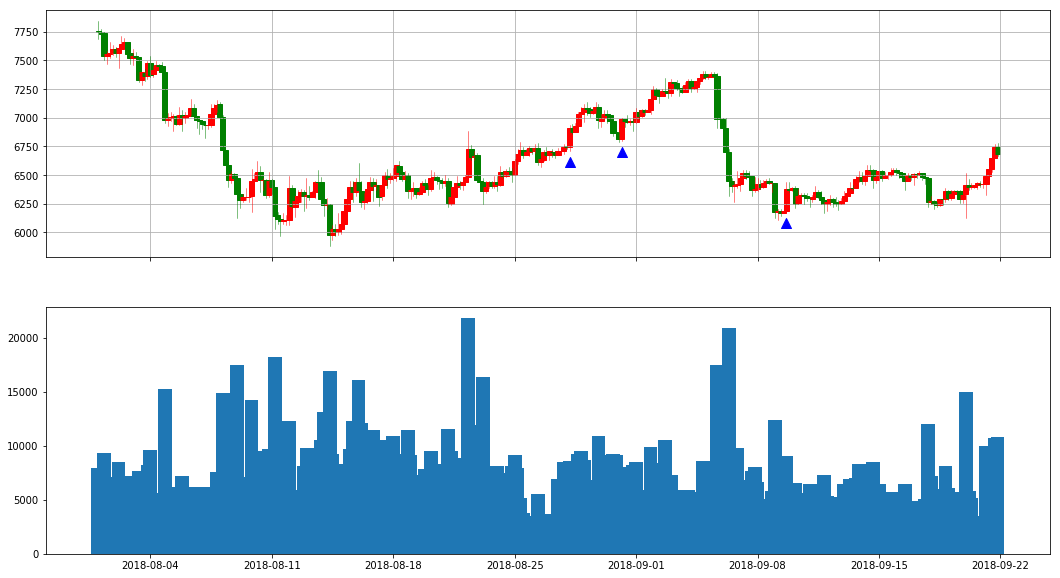

In [9]:
draw_candle(candle, scatterBigUpX, scatterBigUpY)

#大阳线 找到符合设定的大阳线条件的数据做出蜡烛图，判断比特币汇率变化的反转信号和持续信号，观察变化趋势。可以看到几次预测的效果较好，大阳线反噬大阴线且之后价格在一段时间内上升。
在大阳线反噬大阴线的时候进场（做多），反之，退场（做空）。

In [11]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
import pandas as pd
## 加freq参数

start = time()
path = r'/min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '4H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [12]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [13]:
#A 1
def RankPct(df):
    return df.rank(axis=1, pct=True)

In [14]:
alpha1=dv.add_formula('alpha1_C','RankPct(Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5))',add_data=True, register_funcs={'RankPct':RankPct})

In [15]:
alpha1_change = dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True, register_funcs={'RankPct':RankPct})

Field [alpha1_C] is overwritten.


In [16]:
alpha1_plot = dv.get_ts('alpha1_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

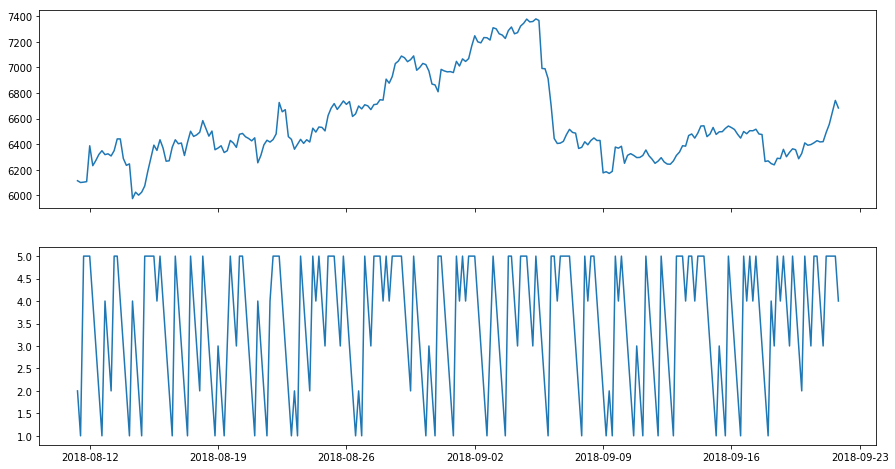

In [17]:
plot_chart(close, alpha1_plot)

#用alpha1因子来研究所选取的因子与价格之间的关系，从而做出假设，标记进出场信号。
#第一张图用收盘价表示价格图变化趋势，第二张图是alpha1因子在不同时间的数值变化趋势。可以看出alpha1因子对于比特币汇率的收益预测较为有效，因此选取的alpha1因子是较好的。
进出场信号：alpha1因子由小变大时进场（做多），由大变小时退场（做空）。

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [21]:
# 1、定义calcuate对均线进行打分
import talib as ta
import numpy as np
import pandas as pd

def calculate(close, timePeriod):
    mas = ta.MA(close.iloc[:,0].values, timePeriod)
    mal = ta.MA(close.iloc[:,0].values, 5*timePeriod)
    df = pd.DataFrame({'long': mal, 'short': mas}, index=close.index).dropna()
    df['direction'] = list(map(lambda s, l: 1 if s > l else 0, df['short'], df['long']))
    return df['direction']

In [22]:
# signalDf
dvClose = dv.get_ts('close',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf = pd.DataFrame({t: calculate(dvClose, t) for t in x})

In [23]:
#2、信号的加总相乘
signalDf['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf.iterrows()}) 

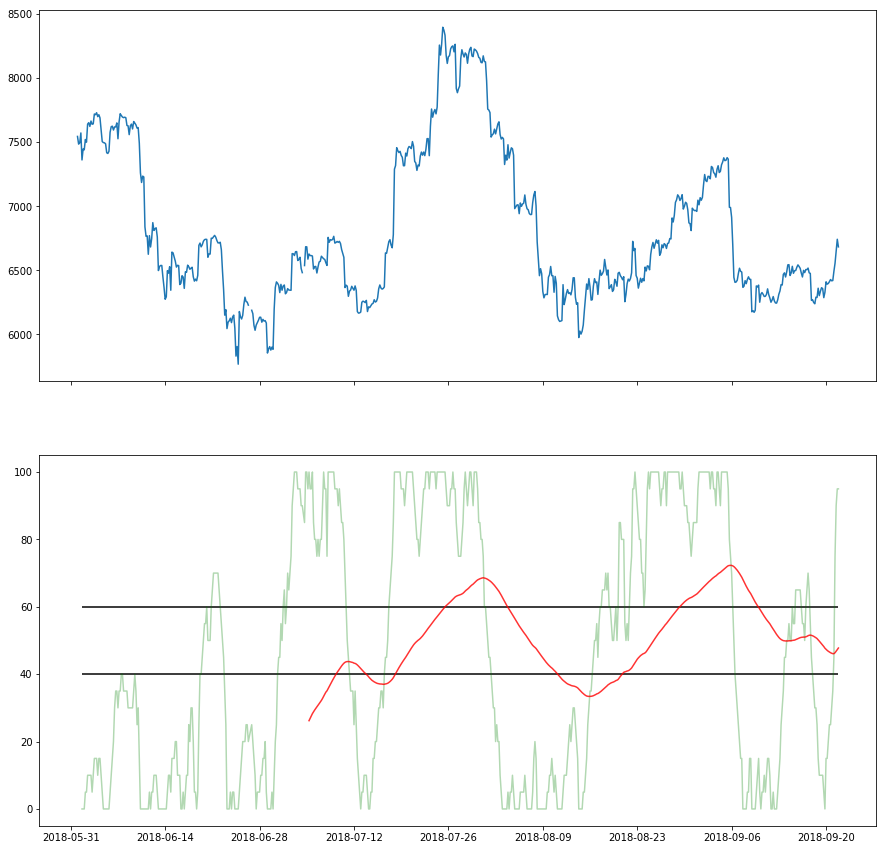

In [24]:
# 3、绘图观察
import matplotlib.pyplot as plt
from talib import abstract

fig, (ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv.get_ts('close',date_type='datetime'))
ax1.plot(signalDf['signal'], 'g', alpha=0.3)
ax1.plot(abstract.EMA(signalDf,200,price='signal'), 'r', alpha=0.8)
ax1.hlines(60, signalDf['signal'].index[0], signalDf['signal'].index[-1])
ax1.hlines(40, signalDf['signal'].index[0], signalDf['signal'].index[-1])
plt.show()

In [25]:
 #4、定义信号事件
def signalAppend(signalDf):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "BTCUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signalSe = signalDf.signal.unstack()
    dv.append_df(signalSe,'signalSe')
signalAppend(signalDf)

In [26]:
# 5、设定进出场条件
long = dv.add_formula('long','If((signalSe>=60) && (Delay(signalSe,1)<60), 2, 0)', add_data=True)
short = dv.add_formula('short','If((signalSe<=40) && (Delay(signalSe,1)>40), -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

In [28]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


In [29]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win   loss     all
t-stat              7.508 -3.397   0.500
p-value             0.005  0.012   0.627
mean                0.101 -0.035   0.010
std                 0.023  0.027   0.069
info_ratio          4.335 -1.284   0.151
skewness           -0.564 -0.322   0.489
kurtosis           -1.277 -1.051  -1.202
pct5                0.070 -0.076  -0.072
pct25               0.088 -0.048  -0.041
pct50               0.108 -0.038  -0.006
pct75               0.121 -0.006   0.073
pct95               0.123 -0.003   0.122
occurance           4.000  8.000  12.000
win_ratio             NaN    NaN   0.333
win_mean/loss_mean    NaN    NaN   2.897


In [30]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                         win   loss    all
t-stat                   NaN -3.322 -0.137
p-value                  NaN  0.045  0.898
mean                0.144000 -0.043 -0.005
std                 0.000000  0.022  0.077
info_ratio               inf -1.918 -0.068
skewness            0.000000  0.298  1.263
kurtosis           -3.000000 -1.607 -0.076
pct5                0.144000 -0.064 -0.064
pct25               0.144000 -0.063 -0.063
pct50               0.144000 -0.047 -0.032
pct75               0.144000 -0.027 -0.011
pct95               0.144000 -0.014  0.113
occurance           1.000000  4.000  5.000
win_ratio                NaN    NaN  0.200
win_mean/loss_mean       NaN    NaN  3.380


In [31]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              8.121  -4.800   0.323
p-value             0.001   0.001   0.751
mean                0.110  -0.038   0.006
std                 0.027   0.026   0.072
info_ratio          4.061  -1.447   0.081
skewness           -0.475  -0.115   0.733
kurtosis           -0.974  -1.216  -0.919
pct5                0.071  -0.073  -0.068
pct25               0.096  -0.063  -0.043
pct50               0.121  -0.038  -0.011
pct75               0.123  -0.010   0.065
pct95               0.140  -0.004   0.128
occurance           5.000  12.000  17.000
win_ratio             NaN     NaN   0.294
win_mean/loss_mean    NaN     NaN   2.927


对第二个假设进行验证，检验alpha1因子。信号加总相乘后，60分以上做多，40分以下做空。